In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

sklearn.set_config(transform_output="pandas")

X, y = fetch_openml("mnist_784", return_X_y=True, as_frame=True)
scaler = MinMaxScaler()
X = scaler.fit_transform(X)  # type: ignore


In [123]:
from typing import Any


def get_sample(
    X: pd.DataFrame, y: pd.Series, size: int, *, seed: Any = None
) -> tuple[pd.DataFrame, pd.Series]:
    
    X_sample = X.sample(size, random_state=seed)
    y_sample = y[X_sample.index]
    X_sample.reset_index(drop=True, inplace=True)
    y_sample.reset_index(drop=True, inplace=True)
    return X_sample, y_sample

size = 256
X_sample, y_sample = get_sample(X, y, size, seed=42)


In [124]:
def get_source_targets(
    X: pd.DataFrame, y: pd.Series, source: str, target: str
) -> tuple[int, list[int]]:
    s = X[y == source].index[0]
    t = X[y == target].index.tolist()
    return s, t


s, ts = get_source_targets(X_sample, y_sample, "0", "1")
s, ts[:5]


(5, [17, 27, 38, 56, 60])

In [125]:
def cost_fn(df: pd.DataFrame, i: int, j: int) -> list[tuple[float, float]]:
    a = df.iloc[i]
    b = df.iloc[j]

    x = np.subtract(a, b)
    l2 = np.linalg.norm(x, 2, 0)

    x = np.abs(x, x)
    sum_of_diff = x.sum()

    x = np.maximum.reduce((a, b), out=x)
    sum_of_max = x.sum()

    l1 = sum_of_diff / sum_of_max

    return [(l1, l2)]  # type: ignore


cost_fn(X_sample, s, ts[0])


[(0.889246619446233, 12.383230217475273)]

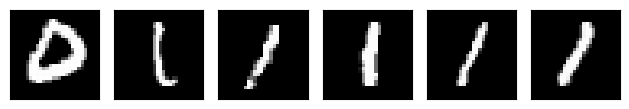

In [126]:
from matplotlib import pyplot as plt


def plot_images(df, indices: list[int]):
    fig, axes = plt.subplots(
        1,
        len(indices),
        subplot_kw={"xticks": [], "yticks": []},
        layout="tight",
        squeeze=False,
    )
    axes = axes[0]
    for ax, i in zip(axes, indices):
        ax.imshow(df.iloc[i].to_numpy().reshape(28, 28), cmap="gray")


plot_images(X_sample, [s] + ts[:5])


In [127]:
from algo import recourse
from functools import partial

graph, dist = recourse(
    X_sample, y_sample, 8, s, ts, partial(cost_fn, X_sample), limit=16
)


In [128]:
from algo import backtracking


paths = backtracking(graph, dist, s, size)
paths


[[151, 241, 32, 73, 5], [151, 241, 32, 99, 5], [17, 222, 131, 185, 5]]

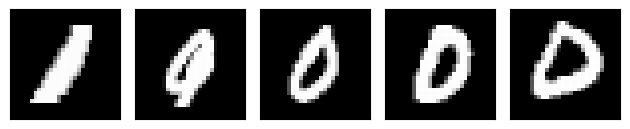

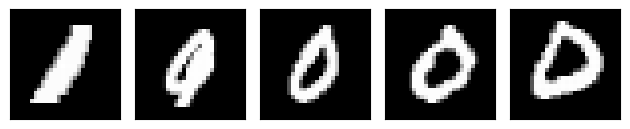

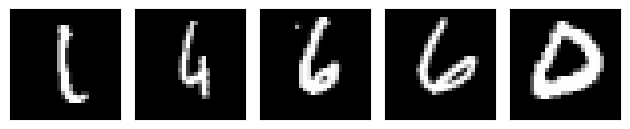

In [129]:
for path in paths:
    plot_images(X_sample, path)
